# Deep neural network-based models for predicting mRNA editing

Bidirectional LSTM with Attention Layer

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
from keras import backend as K

In [ ]:
########################################
# PARAMS
########################################
fname      = 'hg38_RS_DL_ES_NES_rand1000_Pad_W100_BALANCED_1_1_CODED2CH.csv'
#fname      = 'DATASET_PAD1.csv'
separator_char=';'
ptrain     = 0.7
model_name = 'TFM_LSTMBidiAttentionW100'
num_lstm_units=256
n_epochs=20
batch_size=32
categories_size=20
padding=True
random_seed=2022
########################################

We can run this notebook in two environments:
+ Googlr Colab Pro (Cloud)
+ Jupyter Lab (Locally)

In [ ]:
#CHECK GOOGLE COLAB
GOOGLE_COLAB=False
if 'google.colab' in str(get_ipython()):
  GOOGLE_COLAB=True  
  print('Running on CoLab')
else:
  print('Not running on CoLab')

Running on CoLab


Checking if GPU is available and GPU characteristics.

In [ ]:
#CHECK GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Num GPUs Available: {}'.format(len(tf.config.list_physical_devices('GPU'))))
  print('Found GPU at: {}'.format(device_name))
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  if gpu_info.find('failed') >= 0:
     print('Not connected to a GPU')
  else:
     print(gpu_info)

Num GPUs Available: 1
Found GPU at: /device:GPU:0
Sat May 28 07:52:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |    375MiB / 16280MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [ ]:
if padding==True:
    categories_size=21

if GOOGLE_COLAB==False:
    data_dir = '../data/datasets/RAND1000/W100'
    models_dir = './SAVED_MODELS'

else:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    #set the path to find RNAEd module
    sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')    
    data_dir  = '/content/drive/MyDrive/DATASETS/RAND1000/W100'
    models_dir= '/content/drive/MyDrive/MODELS'

#We can save best model and last model
best_model = 'best_model_'+model_name+'.h5'
last_model =  model_name+'.h5'
lastmodelfile = os.path.join(models_dir, last_model)
print("LAST MODEL FILE: {}".format(lastmodelfile))
bestmodelfile = os.path.join(models_dir, best_model)
print("BEST MODEL FILE: {}".format(bestmodelfile))
datafile = os.path.join(data_dir, fname)    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LAST MODEL FILE: /content/drive/MyDrive/MODELS/TFM_LSTMBidiAttentionW100.h5
BEST MODEL FILE: /content/drive/MyDrive/MODELS/best_model_TFM_LSTMBidiAttentionW100.h5


We read the data.

In [ ]:
print("DATASET: {}".format(datafile))
dataraw = pd.read_csv(datafile,sep=separator_char)
print("shape dataraw={}".format(dataraw.shape))

DATASET: /content/drive/MyDrive/DATASETS/RAND1000/W100/hg38_RS_DL_ES_NES_rand1000_Pad_W100_BALANCED_1_1_CODED2CH.csv
shape dataraw=(306862, 204)


We will divide the data into: train, validation and test.
The three datastes should be well balanced.

In [ ]:
X=dataraw.iloc[:,3:]
Y=dataraw['EDITING']
print(X.head)

<bound method NDFrame.head of         P1  P2  P3  P4  P5  P6  P7  P8  P9  P10  ...  P192  P193  P194  P195  \
0        6  16   0   6   1  11   1  16  15    1  ...    16    11    11     6   
1       11   6  11   1  18  18  18  13  18    8  ...    17     2     2    17   
2       15  15  10   0   5   0  15   5   5   15  ...     8     3    11    16   
3        6   6  15   0   5   5  15   0   5    6  ...    11    16    13     6   
4       16  11  16   6   3   8   3   1  11   11  ...     7     7    17    17   
...     ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...   ...   ...   ...   ...   
306857   7   2  12   2   2  12   2  17   7    2  ...     0     0     0     0   
306858  11  16   6  16   6  16  11  16  13    6  ...     4    11     6    16   
306859   6   3  11  11  16  16  16  16   1    1  ...    11     0    10     0   
306860  16  11   6   1   6  16   6   3  13    8  ...     7    16    16    16   
306861  11   1   6   1  16   6   1  16  16   17  ...     0    15    15     0   

        P

In [ ]:
# Train and Validation+Test
x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=1-ptrain, random_state=random_seed)
#Validation and test: 0.5/0.5
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=random_seed)

print("x_train:{} y_train:{}".format(x_train.shape,y_train.shape))
print("x_val: {} y_val: {}".format(x_val.shape,y_val.shape))
print("x_test: {} y_test: {}".format(x_test.shape,y_test.shape))
print("TRAIN LABELS:")
print(y_train.value_counts())
print("VALIDATION LABELS:")
print(y_val.value_counts())
print("TEST LABELS:")
print(y_test.value_counts())

x_train:(214803, 201) y_train:(214803,)
x_val: (46029, 201) y_val: (46029,)
x_test: (46030, 201) y_test: (46030,)
TRAIN LABELS:
1    107504
0    107299
Name: EDITING, dtype: int64
VALIDATION LABELS:
0    23087
1    22942
Name: EDITING, dtype: int64
TEST LABELS:
0    23045
1    22985
Name: EDITING, dtype: int64


We instantiate 3 DataGenerator objects that convert from integer to one-hot

In [ ]:
#DataGenerator converts on the fly from raw data to one-hot
from RNAEd import DataGenerator

num_nucleosides = x_train.shape[1]
num_tokens = categories_size

training_generator   = DataGenerator(x_train, y_train, batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
validation_generator = DataGenerator(x_val,   y_val,   batch_size=batch_size, seq_size=num_nucleosides, categories_size=categories_size, shuffle=True)
test_generator       = DataGenerator(x_test,  y_test,  batch_size=1,seq_size=num_nucleosides, categories_size=categories_size, shuffle=False )

## Attention Layer

In [ ]:
from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    ''' heredamos de la clase layer '''
    def __init__(self):
        super(attention,self).__init__()
    
    #En el método build definimos los pesos
    def build(self, input_shape):
        # Define the shape of the weights and bias in this layer
        # The layer has just 1 lonely neuron
        
        # For convenience sake, add a couple of properties
        self.num_dim_pernucleoside = input_shape[-1] ## 1092
        self.nucleosides_persequence = input_shape[-2]  ## 41
        num_units = 1
        
        
        #Weights shape=(1092,1)
        self.W=self.add_weight(name="att_weight", shape=(self.num_dim_pernucleoside,num_units),
                               initializer="normal")
        #bias  shape=(41,1)
        self.b=self.add_weight(name="att_bias", shape=(self.nucleosides_persequence,num_units),
                               initializer="zeros")
        super(attention,self).build(input_shape)
    
    #en el método call definimos la lógica
    #esta es la implementación clásica
    def call_classic(self, x):
        # x is the input tensor of 2 x num_units=1092 dimensions
        """ We multiply the inputs ‘x’ of shape (41 * 1092) by the layer weights ‘w’ 
        of shape (1092 * 1) and obtain a (41 * 1) matrix. We add the bias (41 * 1) 
        and pass the output through any activation layer. So we now have 41 * 1 values 
        We take a softmax of these values. Softmax squashes these into values in the 
        range between 0, and 1 whose sum is 1. These are the 41 attention weights. 
        We multiply each attention weight by the respective nucleoside hidden states and sum up and we are done. 
        We now have the ‘attention adjusted output’ state ready to be fed to the next layer."""
        
        #e = K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)  # Necesario en algunos frameworks
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        # return the outputs. 'a' is the set of 41 attention weights
        # the second variable is the 'attention adjusted o/p state'
        return a, K.sum(output, axis=1)
  
    #esta implementación es más robusta
    def call(self, x):
        """ Es lo mismo de antes pero más robusto a distintos frameworks"""
        e = K.tanh(K.dot(x,self.W)+self.b)
        e = Flatten()(e)
        a = Activation('softmax')(e) 
        # Don't manipulate 'a'. It needs to be 'return'ed intact
        temp = RepeatVector(self.num_dim_pernucleoside)(a) # (?,41) becomes (?,1092,41)
        temp = Permute([2,1])(temp) # change from (?,1092,41) to (?,41,1092)
 
        output = Multiply()([x,temp])# Apply weight to each of the 1092 dim
        output = Lambda(lambda values: K.sum(values, axis=1))(output)
        return a, output

## Model defined from the scratch

In [ ]:
#MODELOS REDES NEURONALES LSTM CON CAPAS DE ATENCIÓN
# Import the libraries required in this example:

num_nucleosides = x_train.shape[1]
num_tokens = categories_size
print("Number of units={}".format(num_lstm_units))
#Definimos la estructura con el Functional model
inputs = keras.Input(shape=(num_nucleosides,num_tokens), name="INPUTS")
lstm_out   = layers.Bidirectional(layers.LSTM(num_lstm_units,return_sequences=True), name="LSTM_BI")(inputs)
dropout= layers.Dropout(0.2)(lstm_out)

#===============================
#METHOD 1: using a custom layer:
#===============================
#La salida de la capa bidireccional será un de 1 batch=None numero de secuencas, 
#de 41 nucleosidos(timesteps) de 2xnúmero_unidades=2*546=1092
#Es decir (None,41,1092)
#---------uncomment here--------------------
#a ,att_d = attention()(dropout)
#-----------------------------
#La capa de atención debe retornarnos un peso para cada hidden state 
#correspondiente a cada elemento de la secuencia o timestep
#es decir, nos debe dar un peso por cada nuceósido, es decir, nos debe dar (41,1)
#Pero relamente no queremos esos pesos, sino la suma del vector de hidden states
#que es lo que conforma el verdadero contexto, y que tendrá dimensión (None,1,1092)
#Esta salida es lo que se llama el "attention adjusted output state".
#Para ello, nuestra capa de atención debe entrenar (1092,1) pesos, ya que debemos 
#entrenar un peso por cada dimensión del espacio vectorial del contexto.
#(1092,1) x (41,1092) = (41,1) los pesos de atención
#(1092,1) son los pesos de la capa.
#===============================================================

#===============================
#METHOD 2: using regular layers:
#===============================

#---------uncomment here--------------------
e=Dense(1, activation='tanh')(dropout)
# Now do all the softmax business taking the above o/p
e=Flatten()(e)
a=Activation('softmax')(e)
temp=RepeatVector(2*num_lstm_units)(a)
temp=Permute([2, 1])(temp)
# multiply weight with lstm layer o/p
output = merge.Multiply()([lstm_out, temp])
# Get the attention adjusted output state
att = Lambda(lambda values: K.sum(values, axis=1))(output)
#-----------------------------

#===============================================================
outputs= layers.Dense(1, activation='sigmoid', name="OUTPUT")(att)
#Creamos el modelo
model_from_scratch  = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

#Mostramos el modelo
print(model_from_scratch.summary())

Number of units=256
Model: "TFM_LSTMBidiAttentionW100"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 201, 21)]    0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 201, 512)     569344      ['INPUTS[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 201, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 201, 1)       513         ['dropout[0][0]']                
                                                      

In [ ]:
#Compilation reset all weights
model_from_scratch.compile(optimizer=keras.optimizers.Adam(),
                           loss     =keras.losses.BinaryCrossentropy(),
                           metrics  =[keras.metrics.BinaryAccuracy()])

model=model_from_scratch

Recover last model, best model or generate a new model

In [ ]:
#Load the trained model from disk
import os.path

best_model_accuracy =0
last_model_accuracy =0

if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)
    print("Testing best model file: {}".format(bestmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    best_model_accuracy = results[1]
    print("best model accuracy: {}".format(best_model_accuracy))    

if os.path.exists(lastmodelfile):
    model = tf.keras.models.load_model(lastmodelfile)
    print("Testing last complete model file: {}".format(lastmodelfile))
    results = model.evaluate(validation_generator,verbose=1)
    last_model_accuracy = results[1]
    print("last model accuracy: {}".format(last_model_accuracy))           


if best_model_accuracy > last_model_accuracy:
   model = tf.keras.models.load_model(bestmodelfile)
   print("Selected best model saved: {}".format(bestmodelfile))
else:
  if last_model_accuracy > best_model_accuracy:
     print("Selected last model saved: {}".format(lastmodelfile))
  else:
     print("Selected new untrained model")


# Show the model architecture
model.summary()

Selected new untrained model
Model: "TFM_LSTMBidiAttentionW100"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUTS (InputLayer)            [(None, 201, 21)]    0           []                               
                                                                                                  
 LSTM_BI (Bidirectional)        (None, 201, 512)     569344      ['INPUTS[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 201, 512)     0           ['LSTM_BI[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 201, 1)       513         ['dropout[0][0]']                
                                             

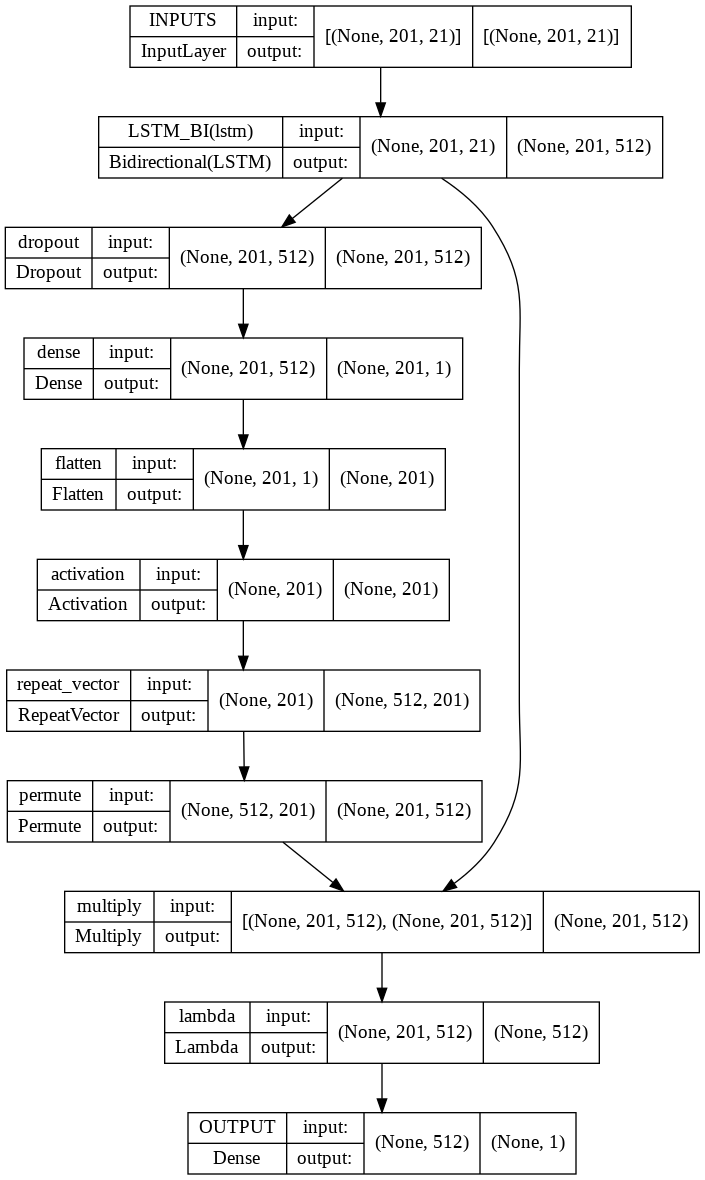

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(bestmodelfile, 
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto', 
                             save_freq='epoch')

callback=EarlyStopping(monitor='val_loss', 
                       min_delta=0, 
                       patience=3, 
                       verbose=1, 
                       mode='auto',
                       baseline=None, 
                       restore_best_weights=True)

In [16]:
with tf.device(device_name):#Use GPU if available
    history=model.fit(training_generator,epochs=n_epochs,
                      validation_data=validation_generator,
                      callbacks=[checkpoint,callback],verbose=1)

Epoch 1/20
6712/6712 [==============================] - ETA: 0s - loss: 0.4177 - binary_accuracy: 0.8280
Epoch 1: val_loss improved from inf to 0.35480, saving model to /content/drive/MyDrive/MODELS/best_model_TFM_LSTMBidiAttentionW100.h5
6712/6712 [==============================] - 876s 130ms/step - loss: 0.4177 - binary_accuracy: 0.8280 - val_loss: 0.3548 - val_binary_accuracy: 0.8697
Epoch 2/20
6712/6712 [==============================] - ETA: 0s - loss: 0.2986 - binary_accuracy: 0.8992
Epoch 2: val_loss improved from 0.35480 to 0.27394, saving model to /content/drive/MyDrive/MODELS/best_model_TFM_LSTMBidiAttentionW100.h5
6712/6712 [==============================] - 861s 128ms/step - loss: 0.2986 - binary_accuracy: 0.8992 - val_loss: 0.2739 - val_binary_accuracy: 0.9108
Epoch 3/20
6712/6712 [==============================] - ETA: 0s - loss: 0.2677 - binary_accuracy: 0.9149
Epoch 3: val_loss improved from 0.27394 to 0.25243, saving model to /content/drive/MyDrive/MODELS/best_model_TF

In [17]:
#We always save the last model.
#Last model can be triggered by early stopping
n_epochs_trained = len(history.history['loss'])
print("Trained epochs: {} of {}".format(n_epochs_trained,n_epochs))
model.save(lastmodelfile)    

Trained epochs: 16 of 20


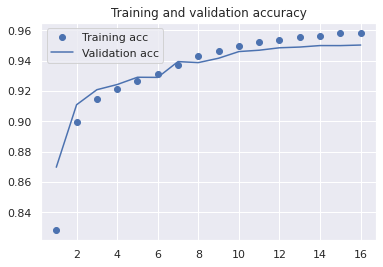

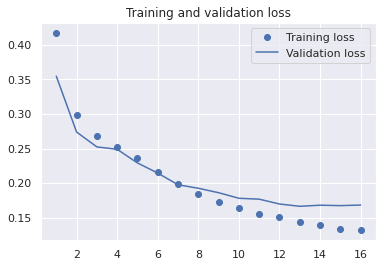

In [18]:
#PLOT ACCURACY AND LOSS

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We recover the best model saved.

In [19]:
if os.path.exists(bestmodelfile):
    model = tf.keras.models.load_model(bestmodelfile)

We evaluate the best model on validation data.

In [26]:
#EVALUATE TEST DATASET
print("Evaluate models on validation data")
results_model = model.evaluate(validation_generator,verbose=1)
print ('Accuracy on validation data:',round(results_model[1],3))
print ('Loss on validation data:',round(results_model[0],3))

Evaluate models on validation data
1438/1438 [==============================] - 127s 88ms/step - loss: 0.1665 - binary_accuracy: 0.9489
Accuracy on validation data: 0.949
Loss on validation data: 0.166


We make predictions on test data, never used during training nor validation

In [27]:
#PREDICTIONS
print("Make predictions on test data")
model_prediction = model.predict(test_generator,verbose=1)
model_prediction_binary = (model_prediction > 0.5).astype("int32")

Make predictions on test data
46030/46030 [==============================] - 347s 8ms/step


In [28]:
print(x_test.shape)
print(y_test.shape)
print(model_prediction.shape)
print(model_prediction_binary.shape)

(46030, 201)
(46030,)
(46030, 1)
(46030, 1)


In [46]:
model_prediction_binary = (model_prediction > 0.5).astype("int32")
#METRICS QUALITY CLASSIFICATION
print("MODEL "+model_name+"\n---------------------------------")
kappa = cohen_kappa_score(y_test, model_prediction_binary)
print ('Kappa:',round(kappa,3))
print(classification_report(y_test, model_prediction_binary))

MODEL TFM_LSTMBidiAttentionW100
---------------------------------
Kappa: 0.897
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     23045
           1       0.92      0.98      0.95     22985

    accuracy                           0.95     46030
   macro avg       0.95      0.95      0.95     46030
weighted avg       0.95      0.95      0.95     46030



Text(80.90000000000006, 0.5, 'Truth Editing')

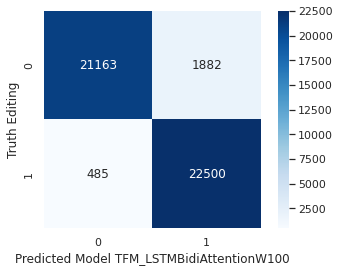

In [47]:
from sklearn.metrics import confusion_matrix, precision_score, cohen_kappa_score, classification_report
import seaborn as sns; sns.set()
# PLOT CONFUSION MATRIX
plt.figure()
cm = confusion_matrix(y_test,model_prediction_binary)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,cmap="Blues")
plt.xlabel('Predicted Model '+ model_name)
plt.ylabel('Truth Editing')

AUC: 0.97


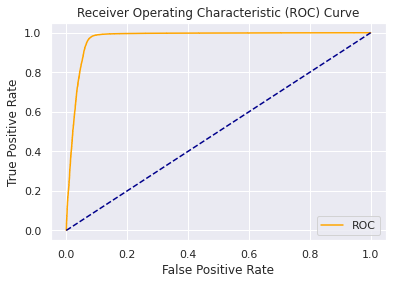

In [48]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color="orange", label="ROC")
    plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

auc = roc_auc_score(y_test, model_prediction)
print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, model_prediction)
plot_roc_curve(fpr, tpr)
